In [1]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

from ast import literal_eval

import re
import string

In [2]:
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
# from scipy.linalg import svd

# from sklearn.decomposition import PCA

from sklearn.decomposition import TruncatedSVD

from scipy.sparse import csr_matrix

from sklearn.preprocessing import StandardScaler

In [4]:
import seaborn as sns

from matplotlib import pyplot as plt
%config InlineBackend.figure_formats = ['retina']  # or svg
%matplotlib inline

In [5]:
# Make some room to see stuff (i.e. drop display limits on Pandas rows & cols - be careful w/ big df's!)

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', None)

## 1) Read in the data

In [6]:
movies = pd.read_csv('final_dataset.csv', lineterminator='\n', index_col=0)
print(movies.shape)
movies.head()

(47723, 8)


,movieId,tmdbId,imdbId,title,genres,overview,director,actors
0,1,862,114709,Toy Story,"['Adventure', 'Animation', 'Children', 'Comedy...","Led by Woody, Andy's toys live happily in his ...",john_lasseter,"['tom_hanks', 'tim_allen', 'don_rickles', 'jim..."
1,2,8844,113497,Jumanji,"['Adventure', 'Children', 'Fantasy']",When siblings Judy and Peter discover an encha...,joe_johnston,"['robin_williams', 'kirsten_dunst', 'bradley_p..."
2,3,15602,113228,Grumpier Old Men,"['Comedy', 'Romance']",A family wedding reignites the ancient feud be...,howard_deutch,"['walter_matthau', 'jack_lemmon', 'ann-margret..."
3,4,31357,114885,Waiting to Exhale,"['Comedy', 'Drama', 'Romance']","Cheated on, mistreated and stepped on, the wom...",forest_whitaker,"['whitney_houston', 'angela_bassett', 'loretta..."
4,5,11862,113041,Father of the Bride Part II,['Comedy'],Just when George Banks has recovered from his ...,charles_shyer,"['steve_martin', 'diane_keaton', 'martin_short..."


#### Lists in columns got turned into text strings during save to csv; need to undo that

In [7]:
movies['genres'] = movies['genres'].map(literal_eval)
movies['actors'] = movies['actors'].map(literal_eval)
movies.head()

,movieId,tmdbId,imdbId,title,genres,overview,director,actors
0,1,862,114709,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]","Led by Woody, Andy's toys live happily in his ...",john_lasseter,"[tom_hanks, tim_allen, don_rickles, jim_varney]"
1,2,8844,113497,Jumanji,"[Adventure, Children, Fantasy]",When siblings Judy and Peter discover an encha...,joe_johnston,"[robin_williams, kirsten_dunst, bradley_pierce..."
2,3,15602,113228,Grumpier Old Men,"[Comedy, Romance]",A family wedding reignites the ancient feud be...,howard_deutch,"[walter_matthau, jack_lemmon, ann-margret, sop..."
3,4,31357,114885,Waiting to Exhale,"[Comedy, Drama, Romance]","Cheated on, mistreated and stepped on, the wom...",forest_whitaker,"[whitney_houston, angela_bassett, loretta_devi..."
4,5,11862,113041,Father of the Bride Part II,[Comedy],Just when George Banks has recovered from his ...,charles_shyer,"[steve_martin, diane_keaton, martin_short, kim..."


## 2) Tokenize the 'overview' column

#### Note that there are Named Entities in the overviews (actors, directors, classic literary works, etc.), but we'll skip NER for now

#### Start by removing digits, capital letters and punctuation

In [8]:
alpha = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_and_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())

movies['plot_tokens'] = movies['overview'].map(alpha).map(punc_and_lower)
movies.head()

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens
0,1,862,114709,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]","Led by Woody, Andy's toys live happily in his ...",john_lasseter,"[tom_hanks, tim_allen, don_rickles, jim_varney]",led by woody andy s toys live happily in his ...
1,2,8844,113497,Jumanji,"[Adventure, Children, Fantasy]",When siblings Judy and Peter discover an encha...,joe_johnston,"[robin_williams, kirsten_dunst, bradley_pierce...",when siblings judy and peter discover an encha...
2,3,15602,113228,Grumpier Old Men,"[Comedy, Romance]",A family wedding reignites the ancient feud be...,howard_deutch,"[walter_matthau, jack_lemmon, ann-margret, sop...",a family wedding reignites the ancient feud be...
3,4,31357,114885,Waiting to Exhale,"[Comedy, Drama, Romance]","Cheated on, mistreated and stepped on, the wom...",forest_whitaker,"[whitney_houston, angela_bassett, loretta_devi...",cheated on mistreated and stepped on the wom...
4,5,11862,113041,Father of the Bride Part II,[Comedy],Just when George Banks has recovered from his ...,charles_shyer,"[steve_martin, diane_keaton, martin_short, kim...",just when george banks has recovered from his ...


In [9]:
movies['genres'] = movies['genres'].map(lambda x: [el.lower() for el in x])
movies.head()

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens
0,1,862,114709,Toy Story,"[adventure, animation, children, comedy, fantasy]","Led by Woody, Andy's toys live happily in his ...",john_lasseter,"[tom_hanks, tim_allen, don_rickles, jim_varney]",led by woody andy s toys live happily in his ...
1,2,8844,113497,Jumanji,"[adventure, children, fantasy]",When siblings Judy and Peter discover an encha...,joe_johnston,"[robin_williams, kirsten_dunst, bradley_pierce...",when siblings judy and peter discover an encha...
2,3,15602,113228,Grumpier Old Men,"[comedy, romance]",A family wedding reignites the ancient feud be...,howard_deutch,"[walter_matthau, jack_lemmon, ann-margret, sop...",a family wedding reignites the ancient feud be...
3,4,31357,114885,Waiting to Exhale,"[comedy, drama, romance]","Cheated on, mistreated and stepped on, the wom...",forest_whitaker,"[whitney_houston, angela_bassett, loretta_devi...",cheated on mistreated and stepped on the wom...
4,5,11862,113041,Father of the Bride Part II,[comedy],Just when George Banks has recovered from his ...,charles_shyer,"[steve_martin, diane_keaton, martin_short, kim...",just when george banks has recovered from his ...


#### Tokenize plot summaries - start with simple NLTK word_tokenize:

In [10]:
movies['plot_tokens'] = movies['plot_tokens'].map(word_tokenize)
movies.head()

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens
0,1,862,114709,Toy Story,"[adventure, animation, children, comedy, fantasy]","Led by Woody, Andy's toys live happily in his ...",john_lasseter,"[tom_hanks, tim_allen, don_rickles, jim_varney]","[led, by, woody, andy, s, toys, live, happily,..."
1,2,8844,113497,Jumanji,"[adventure, children, fantasy]",When siblings Judy and Peter discover an encha...,joe_johnston,"[robin_williams, kirsten_dunst, bradley_pierce...","[when, siblings, judy, and, peter, discover, a..."
2,3,15602,113228,Grumpier Old Men,"[comedy, romance]",A family wedding reignites the ancient feud be...,howard_deutch,"[walter_matthau, jack_lemmon, ann-margret, sop...","[a, family, wedding, reignites, the, ancient, ..."
3,4,31357,114885,Waiting to Exhale,"[comedy, drama, romance]","Cheated on, mistreated and stepped on, the wom...",forest_whitaker,"[whitney_houston, angela_bassett, loretta_devi...","[cheated, on, mistreated, and, stepped, on, th..."
4,5,11862,113041,Father of the Bride Part II,[comedy],Just when George Banks has recovered from his ...,charles_shyer,"[steve_martin, diane_keaton, martin_short, kim...","[just, when, george, banks, has, recovered, fr..."


In [11]:
movies['director'] = movies['director'].map(lambda x: [x])
movies.head()

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens
0,1,862,114709,Toy Story,"[adventure, animation, children, comedy, fantasy]","Led by Woody, Andy's toys live happily in his ...",[john_lasseter],"[tom_hanks, tim_allen, don_rickles, jim_varney]","[led, by, woody, andy, s, toys, live, happily,..."
1,2,8844,113497,Jumanji,"[adventure, children, fantasy]",When siblings Judy and Peter discover an encha...,[joe_johnston],"[robin_williams, kirsten_dunst, bradley_pierce...","[when, siblings, judy, and, peter, discover, a..."
2,3,15602,113228,Grumpier Old Men,"[comedy, romance]",A family wedding reignites the ancient feud be...,[howard_deutch],"[walter_matthau, jack_lemmon, ann-margret, sop...","[a, family, wedding, reignites, the, ancient, ..."
3,4,31357,114885,Waiting to Exhale,"[comedy, drama, romance]","Cheated on, mistreated and stepped on, the wom...",[forest_whitaker],"[whitney_houston, angela_bassett, loretta_devi...","[cheated, on, mistreated, and, stepped, on, th..."
4,5,11862,113041,Father of the Bride Part II,[comedy],Just when George Banks has recovered from his ...,[charles_shyer],"[steve_martin, diane_keaton, martin_short, kim...","[just, when, george, banks, has, recovered, fr..."


#### Combine all tokens into one 'corpus' column

In [12]:
cols = ['genres', 'director', 'actors', 'plot_tokens']

movies['corpus'] = ''

for n, row in movies.iterrows():
    val = ''
    for col in cols:
        val += ' '.join(row[col])
        val += ' '
    movies.at[n,'corpus'] = val

In [13]:
movies.head()

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
0,1,862,114709,Toy Story,"[adventure, animation, children, comedy, fantasy]","Led by Woody, Andy's toys live happily in his ...",[john_lasseter],"[tom_hanks, tim_allen, don_rickles, jim_varney]","[led, by, woody, andy, s, toys, live, happily,...",adventure animation children comedy fantasy jo...
1,2,8844,113497,Jumanji,"[adventure, children, fantasy]",When siblings Judy and Peter discover an encha...,[joe_johnston],"[robin_williams, kirsten_dunst, bradley_pierce...","[when, siblings, judy, and, peter, discover, a...",adventure children fantasy joe_johnston robin_...
2,3,15602,113228,Grumpier Old Men,"[comedy, romance]",A family wedding reignites the ancient feud be...,[howard_deutch],"[walter_matthau, jack_lemmon, ann-margret, sop...","[a, family, wedding, reignites, the, ancient, ...",comedy romance howard_deutch walter_matthau ja...
3,4,31357,114885,Waiting to Exhale,"[comedy, drama, romance]","Cheated on, mistreated and stepped on, the wom...",[forest_whitaker],"[whitney_houston, angela_bassett, loretta_devi...","[cheated, on, mistreated, and, stepped, on, th...",comedy drama romance forest_whitaker whitney_h...
4,5,11862,113041,Father of the Bride Part II,[comedy],Just when George Banks has recovered from his ...,[charles_shyer],"[steve_martin, diane_keaton, martin_short, kim...","[just, when, george, banks, has, recovered, fr...",comedy charles_shyer steve_martin diane_keaton...


In [14]:
movies['corpus'][0]

'adventure animation children comedy fantasy john_lasseter tom_hanks tim_allen don_rickles jim_varney led by woody andy s toys live happily in his room until andy s birthday brings buzz lightyear onto the scene afraid of losing his place in andy s heart woody plots against buzz but when circumstances separate buzz and woody from their owner the duo eventually learns to put aside their differences '

#### Initially, let's skip stemming and just go straight to vectorizing

In [15]:
cv1 = CountVectorizer(stop_words='english')

X_cv1 = cv1.fit_transform(movies['corpus'])

doc_term = pd.DataFrame(X_cv1.toarray(), columns=cv1.get_feature_names())

In [16]:
doc_term.shape

(47723, 152684)

#### The above looks like way too many columns - let's adjust max_df & min_df

In [17]:
cv1 = CountVectorizer(stop_words='english', max_df=0.9, min_df=0.03)

X_cv1 = cv1.fit_transform(movies['corpus'])

doc_term = pd.DataFrame(X_cv1.toarray(), columns=cv1.get_feature_names())

In [18]:
doc_term.shape

(47723, 84)

In [19]:
doc_term.head()

,action,adventure,american,animation,begins,best,boy,brother,children,city,comedy,comes,crime,daughter,day,death,decides,discovers,documentary,drama,falls,family,fantasy,father,fi,film,finds,friend,friends,gets,girl,goes,group,help,high,home,horror,house,husband,job,just,life,lives,living,local,long,love,make,man,meets,men,mother,murder,mysterious,mystery,new,night,old,people,police,romance,school,sci,secret,set,small,son,soon,story,takes,thriller,time,town,tries,war,way,western,wife,woman,work,world,year,years,young
0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


#### Now apply dimensionality reduction to the dataset

In [20]:
# U, Sigma, VT = svd(doc_term)

In [21]:
# pca = PCA(n_components=10)
# pca.fit(X_cv1)
# pcafeatures_train = pca.transform(X_cv1)

In [22]:
# X = csr_matrix(X_cv1)

# scaler = StandardScaler(with_mean=False)
# X_cv1_scaled = scaler.fit_transform(X_cv1, )

svd = TruncatedSVD(n_components=40, n_iter=20, random_state=42)
svd.fit(X_cv1.T)

TruncatedSVD(n_components=40, n_iter=20, random_state=42)

In [23]:
print(svd.explained_variance_ratio_)

print(svd.explained_variance_ratio_.sum())

[0.07222679 0.0496728  0.03724535 0.02996666 0.02913185 0.02678343
 0.0256668  0.02451427 0.02285173 0.02178028 0.02111915 0.02033917
 0.02020261 0.01888348 0.01672981 0.01639776 0.01586501 0.0159086
 0.01497068 0.01504425 0.01439625 0.01359441 0.01370228 0.01359913
 0.01287347 0.01260861 0.01230828 0.01110737 0.01094021 0.01076818
 0.0103865  0.01036255 0.01013499 0.00954923 0.0094066  0.00932566
 0.00911696 0.00893768 0.0089045  0.00871142]
0.7360347558571424


In [24]:
svd.components_.T.shape

(47723, 40)

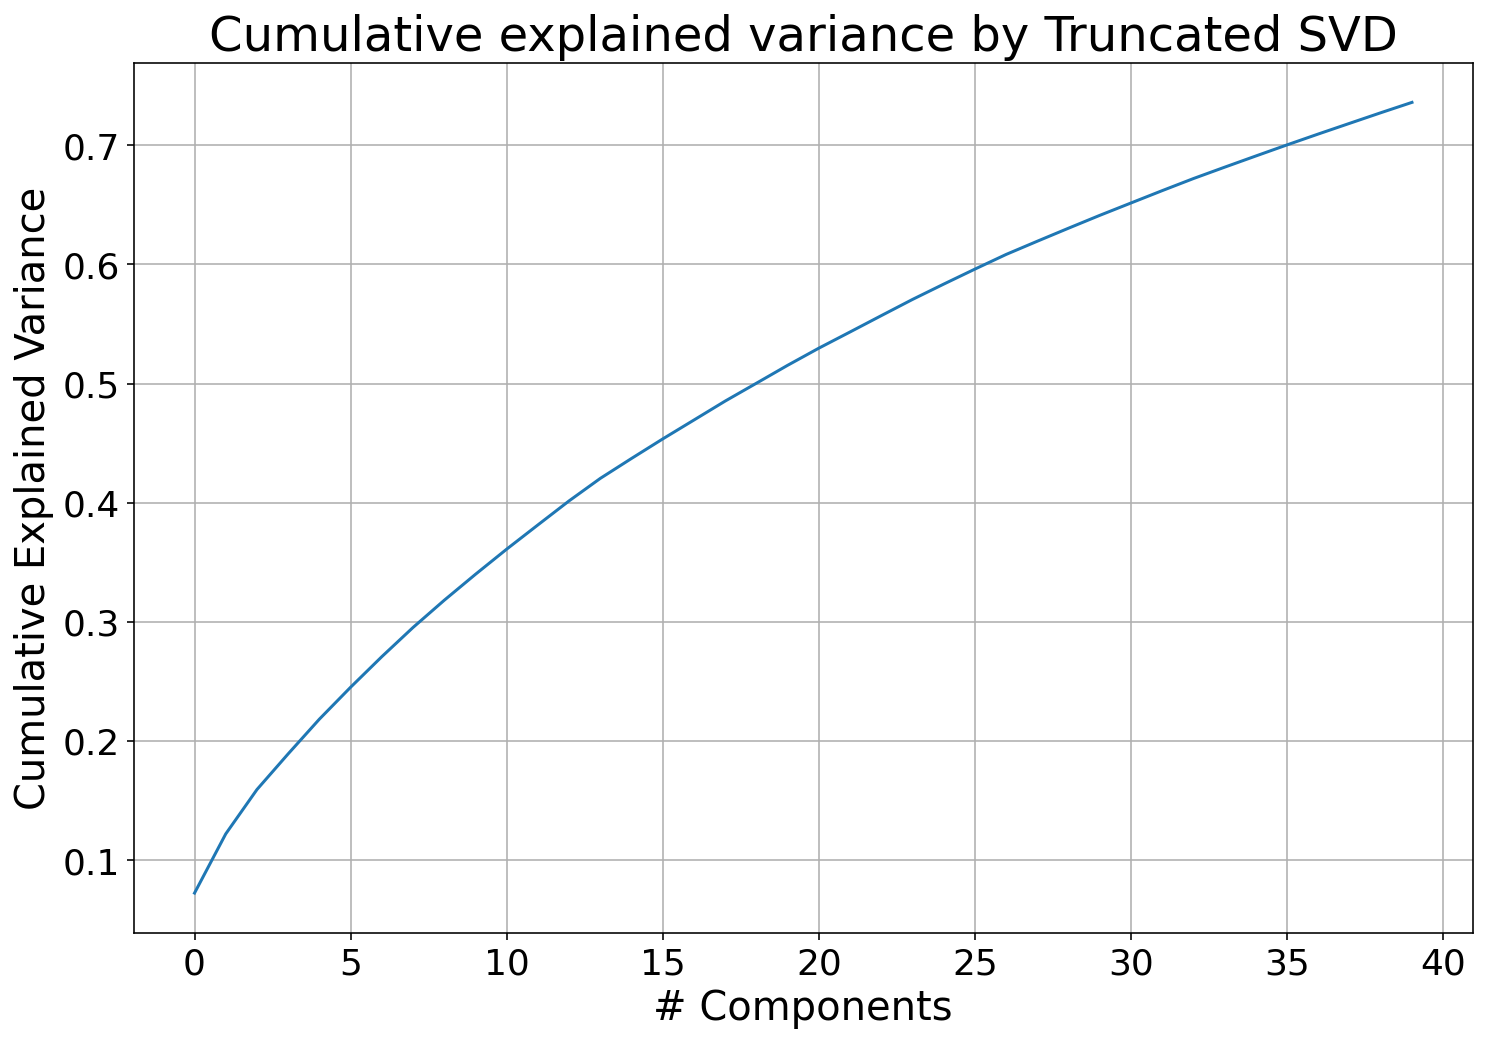

In [25]:
plt.figure(figsize=(12, 8))
plt.plot(np.cumsum(svd.explained_variance_ratio_))
plt.xlabel('# Components', size=20)
plt.ylabel('Cumulative Explained Variance', size=20)
plt.xticks(size=18)
plt.yticks(size=18)
plt.title('Cumulative explained variance by Truncated SVD', size=24)
plt.grid();

In [26]:
mat = pd.DataFrame(data=svd.components_.T, index=movies.index)
mat

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,0.002495,0.007918,0.001899,-0.001495,0.003992,0.001321,0.003664,-0.002742,-0.003049,-0.002758,-0.004108,-0.003821,-0.004907,0.000341,0.004149,-0.001297,0.015056,-0.005396,-0.004327,-0.007597,0.002972,-0.001859,-0.000330,-0.001768,-0.002100,-0.004747,-0.003694,-0.001911,-0.000210,0.001438,-0.004213,0.001048,0.001188,0.001408,-0.001030,0.001367,-0.001659,-0.001117,-0.000612,-0.001327
1,0.001920,0.001223,0.003266,0.002831,0.006250,0.005199,0.003766,-0.002749,-0.001060,-0.002708,-0.002615,-0.001962,-0.002546,0.002209,0.006184,-0.005399,0.016987,0.001289,-0.004135,-0.001304,-0.001806,-0.000966,0.000620,-0.006817,0.000528,-0.001156,0.001656,-0.004632,0.014083,0.001011,-0.006532,-0.000816,0.002540,0.000552,-0.003881,-0.000327,-0.001632,-0.001521,-0.001294,-0.000238
2,0.003588,0.007833,-0.002043,-0.001655,-0.001031,-0.000131,0.002041,-0.002289,0.002808,-0.000690,0.007587,-0.001706,-0.002971,-0.005996,-0.005442,-0.007561,0.000630,0.001767,0.003044,0.003167,0.002245,0.005824,0.001030,0.004470,-0.002980,0.009998,-0.004445,-0.001990,-0.002813,0.001075,-0.003693,-0.000972,0.001815,-0.000317,0.000915,0.000197,-0.000720,0.000270,-0.001202,0.000424
3,0.006456,0.004193,-0.004554,-0.005792,-0.002322,0.000656,-0.002462,0.001008,-0.002028,-0.000235,-0.000199,-0.003470,0.008837,-0.004343,-0.003969,-0.003795,0.003900,-0.001805,-0.001748,0.004062,0.000945,-0.002559,0.001855,-0.000769,-0.003069,0.001110,-0.003062,-0.001859,0.000343,-0.002296,0.008451,-0.002852,-0.006639,-0.007474,-0.000966,0.003526,-0.001307,0.006788,0.003987,-0.000110
4,0.002638,0.006724,-0.000170,-0.001606,-0.000590,-0.002709,0.002703,0.000596,-0.001499,0.001291,0.002211,0.000078,0.000975,-0.000375,-0.001128,0.003299,0.000747,0.001984,-0.001048,-0.003249,-0.000365,0.006630,-0.000733,-0.002561,-0.001481,-0.001945,0.014300,0.001587,-0.005791,0.000578,-0.001730,0.002324,-0.003884,-0.002773,-0.007428,-0.009730,-0.004721,0.004504,0.011466,0.004113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47718,0.007469,-0.002822,-0.002951,0.006408,-0.000144,-0.001919,0.015744,-0.003542,0.003063,-0.005766,-0.002905,-0.003371,0.005978,0.018319,-0.008553,0.005936,-0.003760,0.017799,-0.004961,-0.001192,0.003052,0.015975,0.003410,0.005771,-0.008493,0.021770,-0.007352,0.006429,0.009464,-0.024727,-0.019132,0.031247,-0.013820,0.003529,0.003290,-0.004433,0.002024,0.000500,-0.013349,-0.026084
47719,0.003804,0.013166,-0.001059,-0.005134,0.000106,-0.005162,0.001534,0.002226,-0.003850,0.003247,0.001196,-0.000913,0.000689,-0.000518,0.000727,0.002853,-0.000809,0.001265,-0.002099,-0.002662,-0.000975,0.006136,-0.001216,-0.001504,-0.001149,-0.001515,0.010868,-0.000676,-0.004177,0.003058,-0.001205,-0.001615,-0.000235,-0.000507,-0.000218,-0.001546,-0.002036,0.001140,-0.003653,-0.002550
47720,0.004591,-0.003877,-0.002538,-0.001474,-0.004527,0.004237,0.000596,0.003591,-0.004189,0.002088,-0.006552,0.001867,-0.006142,-0.001124,0.000644,-0.001124,-0.002973,-0.000061,0.000445,-0.001704,-0.003257,0.005199,0.001411,-0.002151,0.005907,-0.002526,-0.004647,0.000103,-0.001266,-0.000856,0.001883,-0.002437,-0.000395,0.001087,-0.002455,-0.000285,-0.000099,-0.000570,0.001102,0.001893
47721,0.003963,-0.003117,0.004933,-0.001705,0.002875,0.003306,0.002124,-0.003875,0.002450,0.008072,-0.008229,-0.012144,0.001132,-0.005114,0.002355,-0.000917,-0.001058,0.001410,0.002685,-0.003802,0.004181,-0.003733,0.005050,-0.003354,-0.003566,-0.003973,-0.003127,-0.001049,-0.001928,0.008356,-0.002995,0.004020,-0.003859,0.000167,-0.005181,0.000438,-0.001856,-0.002080,-0.003149,-0.001960


#### Compute Cosine Similarities in this reduced space

In [27]:
del doc_term

cosine_sim = cosine_similarity(mat, mat)
del mat
print(cosine_sim)

[[ 1.          0.64190141 -0.00755642 ... -0.05292436  0.27513491
  -0.07565027]
 [ 0.64190141  1.         -0.10146543 ... -0.07890658  0.14805368
  -0.08342824]
 [-0.00755642 -0.10146543  1.         ... -0.14967535 -0.081706
  -0.06283244]
 ...
 [-0.05292436 -0.07890658 -0.14967535 ...  1.          0.06364066
   0.11711494]
 [ 0.27513491  0.14805368 -0.081706   ...  0.06364066  1.
   0.04394118]
 [-0.07565027 -0.08342824 -0.06283244 ...  0.11711494  0.04394118
   1.        ]]


In [28]:
cosine_sim.shape

(47723, 47723)

In [29]:
cosine_sim[0,:].argsort()[::-1]

array([20118, 17410, 23127, ..., 40983, 26968, 40466])

In [30]:
cosine_sim[0,:].argsort()[::-1][0:20]

array([20118, 17410, 23127,     0,  3538, 23645, 18202, 26550, 43051,
        2173, 36825, 20549, 21476, 19951, 45053, 39706, 45869,  1876,
        1877,  7954])

In [31]:
cosine_sim[0,[20118, 17410, 23127,     0,  3538, 23645, 18202, 26550, 43051,
        2173, 36825, 20549, 21476, 19951, 45053, 39706, 45869,  1876,
        1877,  7954]]

array([1.        , 1.        , 1.        , 1.        , 0.99907288,
       0.994206  , 0.99156072, 0.99156072, 0.99156072, 0.99156072,
       0.99156072, 0.99150444, 0.98906971, 0.97768882, 0.97768882,
       0.97768882, 0.97768882, 0.97768882, 0.97768882, 0.97768882])

In [32]:
cosine_sim[0,:][0]

1.0

In [33]:
movies.iloc[43051, :]

movieId                                                   178827
tmdbId                                                    346648
imdbId                                                   4468740
title                                               Paddington 2
genres                  [adventure, animation, children, comedy]
overview       Paddington, now happily settled with the Brown...
director                                             [paul_king]
actors         [ben_whishaw, michael_gambon, imelda_staunton,...
plot_tokens    [paddington, now, happily, settled, with, the,...
corpus         adventure animation children comedy paul_king ...
Name: 43051, dtype: object

In [45]:
def recommend(movie_id, len=20):
    movie_idx = movies[movies['movieId'] == movie_id].index[0]
    rec_indices = cosine_sim[movie_idx,:].argsort()[::-1][0:len+1]
    rec_indices = [rec_idx for rec_idx in rec_indices if rec_idx != movie_idx]
    print('Recommendations based on your interest in {}:'
               .format(movies[movies['movieId'] == movie_id]['title'].values[0]))
    recommendations = movies.iloc[rec_indices, np.r_[3:5, 6:8]]
    recommendations['relevancy'] = cosine_sim[movie_idx, rec_indices]
    return recommendations

In [46]:
recommend(1, 10)

Recommendations based on your interest in Toy Story:


,title,genres,director,actors,relevancy
20118,Turbo,"[adventure, animation, children, comedy, fantasy]",[david_soren],"[ryan_reynolds, paul_giamatti, michael_peña, s...",1.000000
17410,Asterix and the Vikings,"[adventure, animation, children, comedy, fantasy]",[stefan_fjeldmark],"[roger_carel, lorànt_deutsch, sara_forestier, ...",1.000000
23127,Hawaiian Vacation,"[adventure, animation, children, comedy, fantasy]",[gary_rydstrom],"[tom_hanks, tim_allen, joan_cusack, don_rickles]",1.000000
3538,The Adventures of Rocky & Bullwinkle,"[adventure, animation, children, comedy, fantasy]",[des_mcanuff],"[rene_russo, jason_alexander, piper_perabo, ra...",0.999073
23645,A Connecticut Yankee in King Arthur's Court,"[adventure, children, comedy, fantasy]",[mel_damski],"[keshia_knight_pulliam, michael_gross, jean_ma...",0.994206
18202,Jack-Jack Attack,"[adventure, animation, children, comedy]",[brad_bird],"[bret_'brook'_parker, bud_luckey, eli_fucile, ...",0.991561
26550,Help! I'm A Fish,"[adventure, animation, comedy]",[stefan_fjeldmark],"[sebastian_jessen, pil_neja, morten_kerrn_niel...",0.991561
43051,Paddington 2,"[adventure, animation, children, comedy]",[paul_king],"[ben_whishaw, michael_gambon, imelda_staunton,...",0.991561
2173,A Bug's Life,"[adventure, animation, children, comedy]",[john_lasseter],"[dave_foley, kevin_spacey, julia_louis-dreyfus...",0.991561
36825,Ribbit,"[adventure, animation, children, comedy]",[mamat_khalid],"[johan, nurul_elfira_loy, awie, aznil_hj_nawawi]",0.991561


In [47]:
movies[movies['title'] == 'Chinatown']

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
1161,1252,829,71315,Chinatown,"[crime, film-noir, mystery, thriller]",Private eye Jake Gittes lives off of the murky...,[roman_polanski],"[jack_nicholson, faye_dunaway, john_huston, pe...","[private, eye, jake, gittes, lives, off, of, t...",crime film-noir mystery thriller roman_polansk...


In [48]:
recommend(1252, 10)

Recommendations based on your interest in Chinatown:


,title,genres,director,actors,relevancy
3816,House of Games,"[crime, film-noir, mystery, thriller]",[david_mamet],"[lindsay_crouse, joe_mantegna, mike_nussbaum, ...",0.812185
8305,Chase a Crooked Shadow,"[crime, film-noir, mystery, thriller]",[michael_anderson],"[richard_todd, anne_baxter, herbert_lom, faith...",0.792463
14415,Nine Dead,"[crime, mystery, thriller]",[chris_shadley],"[melissa_joan_hart, john_terry, chip_bent, law...",0.776976
9279,Hotel Rwanda,"[drama, war]",[terry_george],"[don_cheadle, sophie_okonedo, nick_nolte, fana...",0.704081
16357,Vice,"[crime, film-noir, mystery, thriller]",[raul_inglis],"[michael_madsen, daryl_hannah, mykelti_william...",0.699491
37500,Grandmaster,"[mystery, thriller]",[b._unnikrishnan],"[mohanlal, priyamani, arjun_nandhakumar, babu_...",0.698215
8531,"Farewell, My Lovely","[crime, mystery, thriller]",[dick_richards],"[robert_mitchum, charlotte_rampling, sylvia_mi...",0.690433
31637,Ricochet,"[crime, drama, mystery, thriller]",[nick_gomez],"[john_corbett, julie_benz, kelly_overton, haaz...",0.689453
1489,L.A. Confidential,"[crime, film-noir, mystery, thriller]",[curtis_hanson],"[kevin_spacey, russell_crowe, guy_pearce, jame...",0.685317
18111,3 A.M.,"[crime, mystery, romance]",[lee_davis],"[sarita_choudhury, michelle_rodriguez, arjun_g...",0.683522


In [49]:
movies[movies['title'] == 'Raging Bull']

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
1139,1228,1578,81398,Raging Bull,[drama],"The life of boxer Jake LaMotta, whose violence...",[martin_scorsese],"[robert_de_niro, joe_pesci, cathy_moriarty, fr...","[the, life, of, boxer, jake, lamotta, whose, v...",drama martin_scorsese robert_de_niro joe_pesci...


In [50]:
recommend(1228, 10)

Recommendations based on your interest in Raging Bull:


,title,genres,director,actors,relevancy
19536,The Wayward Bus,[drama],[victor_vicas],"[joan_collins, jayne_mansfield, dan_dailey, ri...",1.000000
13936,Through the Mist,[drama],[jean-philippe_duval],"[sébastien_ricard, joseph_mesiano, dimitri_sto...",1.000000
9294,Beyond the Sea,"[drama, musical]",[kevin_spacey],"[kevin_spacey, kate_bosworth, john_goodman, bo...",1.000000
39630,When the Heavens Fall…,[drama],[risto_jarva],"[eeva-maija_haukinen, erkki_pajala, heikki_häm...",1.000000
27005,Ego,[drama],[lisa_james_larsson],"[martin_wallström, mylaine_hedreul, sissela_ky...",1.000000
5706,Quicksilver,[drama],[thomas_michael_donnelly],"[kevin_bacon, jami_gertz, paul_rodríguez, rudy...",1.000000
30471,The Boy in the Plastic Bubble,[drama],[randal_kleiser],"[john_travolta, glynnis_o'connor, robert_reed,...",0.998141
29911,Loves Her Gun,[drama],[geoff_marslett],"[trieste_kelly_dunn, francisco_barreiro, ashle...",0.996725
38538,Camila Jam,[drama],[murilo_salles],"[leandra_leal, juliano_cazarré, alex_didier, m...",0.983689
3964,The Greatest Story Ever Told,[drama],[george_stevens],"[max_von_sydow, michael_anderson_jr., carroll_...",0.972046


In [51]:
movies[movies['title'] == 'Happy Gilmore']

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
102,104,9614,116483,Happy Gilmore,[comedy],Failed hockey player-turned-golf whiz Happy Gi...,[dennis_dugan],"[adam_sandler, christopher_mcdonald, julie_bow...","[failed, hockey, player, turned, golf, whiz, h...",comedy dennis_dugan adam_sandler christopher_m...


In [52]:
recommend(104, 10)

Recommendations based on your interest in Happy Gilmore:


,title,genres,director,actors,relevancy
20355,The Fireman,[comedy],[charlie_chaplin],"[charlie_chaplin, edna_purviance, lloyd_bacon,...",0.980977
35322,Elvis & Nixon,[comedy],[liza_johnson],"[kevin_spacey, michael_shannon, alex_pettyfer,...",0.980977
21999,Neighbors,[comedy],[nicholas_stoller],"[seth_rogen, zac_efron, rose_byrne, christophe...",0.980977
15751,The Haunted House,[comedy],[buster_keaton],"[buster_keaton, virginia_fox, joe_roberts, edw...",0.980977
44240,Decent People,[comedy],[klim_poplavskiy],"[sergey_shnurov, evgeniy_smorigin, natalya_med...",0.980977
18065,Small Town of Anara,[comedy],[irakli_kvirikadze],"[sesilia_takaishvili, rezo_esadze, ramaz_chkhi...",0.980977
18539,The Newest Pledge,[comedy],[jason_michael_brescia],"[rob_steinhauser, joseph_booton, jason_mewes, ...",0.980977
4183,Nice Dreams,[comedy],[tommy_chong],"[cheech_marin, tommy_chong, stacy_keach, evely...",0.980977
3811,An Everlasting Piece,[comedy],[barry_levinson],"[barry_mcevoy, brían_f._o'byrne, anna_friel, p...",0.980977
33388,Where Can You Go Without the Little Vice?,[comedy],[marino_girolami],"[alvaro_vitali, renzo_montagnani, mario_carote...",0.980977


In [53]:
movies[movies['title'] == "You've Got Mail"]

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
2242,2424,9489,128853,You've Got Mail,"[comedy, romance]","Book superstore magnate, Joe Fox and independe...",[nora_ephron],"[tom_hanks, meg_ryan, greg_kinnear, parker_posey]","[book, superstore, magnate, joe, fox, and, ind...",comedy romance nora_ephron tom_hanks meg_ryan ...


In [54]:
recommend(2424, 10)

Recommendations based on your interest in You've Got Mail:


,title,genres,director,actors,relevancy
481,Much Ado About Nothing,"[comedy, romance]",[kenneth_branagh],"[denzel_washington, keanu_reeves, michael_keat...",1.0
29813,"Yes, We're Open","[comedy, romance]",[richard_wong],"[lynn_chen, parry_shen, sheetal_sheth, kerry_m...",1.0
5453,Continental Divide,"[comedy, romance]",[michael_apted],"[john_belushi, blair_brown, allen_garfield, ca...",1.0
8952,In July,"[comedy, romance]",[fatih_akin],"[moritz_bleibtreu, christiane_paul, mehmet_kur...",1.0
347,Four Weddings and a Funeral,"[comedy, romance]",[mike_newell],"[hugh_grant, andie_macdowell, james_fleet, sim...",1.0
15622,Hands Across the Table,"[comedy, romance]",[mitchell_leisen],"[carole_lombard, fred_macmurray, ralph_bellamy...",1.0
759,Rendezvous in Paris,"[comedy, romance]",[éric_rohmer],"[clara_bellar, antoine_basler, mathias_mégard,...",1.0
29673,The Art of Love,"[comedy, romance]",[emmanuel_mouret],"[emmanuel_mouret, pascale_arbillot, ariane_asc...",1.0
42539,Unleashed,"[comedy, romance]",[finn_taylor],"[kate_micucci, justin_chatwin, steve_howey, ha...",1.0
37934,Here Come the Waves,"[comedy, romance]",[mark_sandrich],"[bing_crosby, betty_hutton, sonny_tufts, ann_d...",1.0


In [55]:
movies[movies['title'] == "Reservoir Dogs"]

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
1020,1089,500,105236,Reservoir Dogs,"[crime, mystery, thriller]",A botched robbery indicates a police informant...,[quentin_tarantino],"[harvey_keitel, tim_roth, michael_madsen, chri...","[a, botched, robbery, indicates, a, police, in...",crime mystery thriller quentin_tarantino harve...


In [56]:
recommend(1089, 10)

Recommendations based on your interest in Reservoir Dogs:


,title,genres,director,actors,relevancy
12297,St. Ives,"[crime, mystery, thriller]",[j._lee_thompson],"[charles_bronson, john_houseman, jacqueline_bi...",1.000000
46229,Chasing Ghosts,"[crime, mystery, thriller]",[kyle_dean_jackson],"[michael_madsen, corey_large, shannyn_sossamon...",0.975203
1320,Murder at 1600,"[crime, drama, mystery, thriller]",[dwight_h._little],"[wesley_snipes, diane_lane, alan_alda, daniel_...",0.940092
39352,Swept Under,"[crime, drama, thriller]",[michel_poulette],"[aaron_ashmore, andré_bédard, stephen_bogaert,...",0.936013
25003,Beck 28 - The Family,"[crime, mystery, thriller]",[mårten_klingberg],"[peter_haber, mikael_persbrandt, ingvar_hirdwa...",0.926996
30730,Mumbai Police,"[crime, mystery, thriller]",[rosshan_andrrews],"[prithviraj_sukumaran, jayasurya, rahman, hima...",0.914679
607,Primal Fear,"[crime, drama, mystery, thriller]",[gregory_hoblit],"[richard_gere, laura_linney, john_mahoney, alf...",0.914348
33533,The Assassin,"[crime, mystery, thriller]",[elio_petri],"[marcello_mastroianni, micheline_presle, crist...",0.913856
49,The Usual Suspects,"[crime, mystery, thriller]",[bryan_singer],"[stephen_baldwin, kevin_spacey, gabriel_byrne,...",0.912941
37668,Seven Sinners,"[crime, thriller]",[albert_de_courville],"[edmund_lowe, constance_cummings, thomy_bourde...",0.910967


In [57]:
movies[movies['title'] == "Star Wars"]

,movieId,tmdbId,imdbId,title,genres,overview,director,actors,plot_tokens,corpus
252,260,11,76759,Star Wars,"[action, adventure, sci-fi]",Princess Leia is captured and held hostage by ...,[george_lucas],"[mark_hamill, harrison_ford, carrie_fisher, pe...","[princess, leia, is, captured, and, held, host...",action adventure sci-fi george_lucas mark_hami...


In [58]:
recommend(260, 10)

Recommendations based on your interest in Star Wars:


,title,genres,director,actors,relevancy
29625,Robot Overlords,"[action, adventure, sci-fi]",[jon_wright],"[ben_kingsley, gillian_anderson, callan_mcauli...",1.0
307,Stargate,"[action, adventure, sci-fi]",[roland_emmerich],"[kurt_russell, james_spader, jaye_davidson, vi...",1.0
14055,Avatar,"[action, adventure, sci-fi, imax]",[james_cameron],"[sam_worthington, zoe_saldana, sigourney_weave...",1.0
17692,King Kong Escapes,"[action, adventure, sci-fi]",[ishirō_honda],"[akira_takarada, mie_hama, rhodes_reason, lind...",1.0
34252,The War in Space,"[action, adventure, sci-fi]",[jun_fukuda],"[kensaku_morita, yuko_asano, ryō_ikebe, masaya...",1.0
39449,Wheels of Fire,"[action, adventure, sci-fi]",[cirio_h._santiago],"[gary_watkins, laura_banks, lynda_wiesmeier, l...",1.0
17218,The War of the Robots,"[action, adventure, sci-fi]",[alfonso_brescia],"[antonio_sabàto, yanti_somer, malisa_longo, pa...",1.0
13137,Flash Gordon,"[action, adventure, sci-fi]",[frederick_stephani],"[buster_crabbe, jean_rogers, frank_shannon, ch...",1.0
1109,The Empire Strikes Back,"[action, adventure, sci-fi]",[irvin_kershner],"[mark_hamill, harrison_ford, carrie_fisher, bi...",1.0
9422,Double Dragon,"[action, adventure, sci-fi]",[james_yukich],"[mark_dacascos, scott_wolf, robert_patrick, kr...",1.0


#### Will try Stemming first (and Lemmatization as an alternative later); Start with PorterStemmer